# Load Dataset 

In [1]:
# example of preparing the horses and zebra dataset
from os import listdir
import numpy as np
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed


In [2]:

# load all images in a directory into memory
def load_images(path, size=(256,256)):
    data_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        if filename.endswith(".jpg"):
            # load and resize the image
    #         print(path + filename)
            pixels = load_img(path + filename, target_size=size)
            # convert to numpy array
            pixels = img_to_array(pixels)
            # store
            data_list.append(pixels)
    return asarray(data_list)
 
# dataset path
path = 'data/'
# load dataset A
dataA1 = load_images(path + 'trainA/')
dataAB = load_images(path + 'testA/')
dataA = vstack((dataA1, dataAB))
print(dataA.shape)
print('Loaded dataA: ', dataA.shape)
# load dataset B
dataB1 = load_images(path + 'trainB/')
dataB2 = load_images(path + 'testB/')
dataB = vstack((dataB1, dataB2))
print('Loaded dataB: ', dataB.shape)
# save as compressed numpy array
filename = 'birds_256.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

(60, 256, 256, 3)
Loaded dataA:  (60, 256, 256, 3)
Loaded dataB:  (60, 256, 256, 3)
Saved dataset:  birds_256.npz


Loaded:  (60, 256, 256, 3) (60, 256, 256, 3)


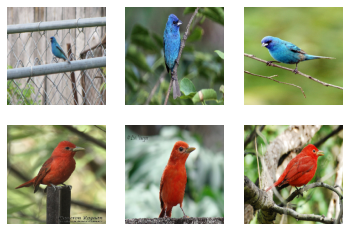

In [3]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('birds_256.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

# Load and Train the Model

In [4]:
# pip install git+https://www.github.com/keras-team/keras-contrib.git

In [9]:
# example of training a cyclegan on the horse2zebra dataset
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
import pandas as pd

# define the discriminator model
def define_discriminator(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # source image input
    in_image = Input(shape=image_shape)
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)
    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # patch output
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(in_image, patch_out)
    # compile model
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model
 
# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    return g
 
# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # c7s1-64
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d128
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # d256
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # u128
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # u64
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # c7s1-3
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    out_image = Activation('tanh')(g)
    # define model
    model = Model(in_image, out_image)
    return model
 
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # ensure the model we're updating is trainable
    g_model_1.trainable = True
    # mark discriminator as not trainable
    d_model.trainable = False
    # mark other generator model as not trainable
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)
    # define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    # define optimization algorithm configuration
    opt = Adam(lr=0.0002, beta_1=0.5)
    # compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model
 
# load and prepare training images
def load_real_samples(filename):
    # load the dataset
    data = load(filename)
    # unpack arrays
    X1, X2 = data['arr_0'], data['arr_1']
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]
 
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return X, y
 
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
    # generate fake instance
    X = g_model.predict(dataset)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y
 
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    # save the first generator model
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    # save the second generator model
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))
 
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # select a sample of input images
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_in[i])
    # plot translated image
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_out[i])
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    pyplot.savefig(filename1)
    pyplot.close()
 
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # stock the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return asarray(selected)
 
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
    # define properties of the training run
    n_epochs, n_batch, = 100, 2
    # determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    g_loss1_list=[]
    g_loss2_list=[]
    dA_loss1_list=[]
    dA_loss2_list=[]
    dB_loss1_list=[]
    dB_loss2_list=[]
    # manually enumerate epochs
    for i in range(n_steps):
        print('training steps {}/{}'.format(i,n_steps))
        # select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        # update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        # summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        # evaluate the model performance every so often
        g_loss1_list.append(g_loss1)
        g_loss2_list.append(g_loss2)
        dA_loss1_list.append(dA_loss1)
        dA_loss2_list.append(dA_loss2)
        dB_loss1_list.append(dB_loss1)
        dB_loss2_list.append(dB_loss2)
        if (i+1) % (bat_per_epo * 1) == 0:
            # plot A->B translation
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            dict = {'g_loss1': g_loss1_list,
                    'g_loss2': g_loss2_list,
                    'dA_loss1': dA_loss1_list,
                    'dA_loss2': dA_loss2_list,
                    'dB_loss1': dB_loss1_list,
                    'dB_loss2': dB_loss2_list
                    }  
            df = pd.DataFrame(dict) 

            # saving the dataframe 
            df.to_csv('loss.csv') 
            # plot B->A translation
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        if (i+1) % (bat_per_epo * 5) == 0:
            # save the models
            save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
# load image data
dataset = load_real_samples('birds_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (60, 256, 256, 3) (60, 256, 256, 3)
training steps 0/3000
>1, dA[2.341,0.911] dB[0.751,1.093] g[17.886,21.072]
training steps 1/3000
>2, dA[2.726,1.445] dB[2.732,2.758] g[19.206,17.234]
training steps 2/3000
>3, dA[1.638,2.237] dB[2.470,1.560] g[16.983,19.519]
training steps 3/3000
>4, dA[3.378,1.522] dB[7.482,1.415] g[17.918,18.330]
training steps 4/3000
>5, dA[2.797,1.473] dB[3.747,1.549] g[14.617,15.923]
training steps 5/3000
>6, dA[3.231,2.242] dB[3.186,0.898] g[14.192,16.230]
training steps 6/3000
>7, dA[1.656,2.823] dB[0.948,0.763] g[14.245,19.445]
training steps 7/3000
>8, dA[3.668,1.632] dB[1.062,0.687] g[13.257,17.804]
training steps 8/3000
>9, dA[1.472,2.122] dB[0.830,0.815] g[13.028,13.767]
training steps 9/3000
>10, dA[0.700,1.541] dB[0.641,1.313] g[11.752,12.325]
training steps 10/3000
>11, dA[0.787,0.634] dB[0.492,0.672] g[11.884,13.486]
training steps 11/3000
>12, dA[0.675,0.512] dB[0.567,0.595] g[12.018,12.211]
training steps 12/3000
>13, dA[0.388,0.481] dB[0.481

>80, dA[0.210,0.246] dB[0.181,0.172] g[6.784,7.347]
training steps 80/3000
>81, dA[0.141,0.189] dB[0.233,0.258] g[7.462,7.678]
training steps 81/3000
>82, dA[0.173,0.159] dB[0.147,0.265] g[6.306,6.914]
training steps 82/3000
>83, dA[0.160,0.178] dB[0.196,0.151] g[6.169,6.143]
training steps 83/3000
>84, dA[0.093,0.082] dB[0.183,0.258] g[7.871,7.967]
training steps 84/3000
>85, dA[0.135,0.156] dB[0.159,0.173] g[6.015,7.225]
training steps 85/3000
>86, dA[0.143,0.256] dB[0.098,0.210] g[7.032,7.291]
training steps 86/3000
>87, dA[0.154,0.121] dB[0.157,0.162] g[7.294,7.719]
training steps 87/3000
>88, dA[0.101,0.160] dB[0.227,0.169] g[7.590,7.946]
training steps 88/3000
>89, dA[0.145,0.097] dB[0.158,0.279] g[6.758,7.490]
training steps 89/3000
>90, dA[0.099,0.191] dB[0.124,0.156] g[7.335,8.369]
training steps 90/3000
>91, dA[0.148,0.229] dB[0.170,0.277] g[8.110,8.037]
training steps 91/3000
>92, dA[0.200,0.135] dB[0.183,0.114] g[7.647,7.359]
training steps 92/3000
>93, dA[0.159,0.153] dB[0

>187, dA[0.155,0.210] dB[0.095,0.128] g[6.349,7.160]
training steps 187/3000
>188, dA[0.157,0.105] dB[0.134,0.077] g[6.563,6.512]
training steps 188/3000
>189, dA[0.160,0.095] dB[0.234,0.119] g[5.595,6.059]
training steps 189/3000
>190, dA[0.044,0.187] dB[0.070,0.155] g[6.710,7.414]
training steps 190/3000
>191, dA[0.168,0.130] dB[0.115,0.118] g[5.654,6.328]
training steps 191/3000
>192, dA[0.161,0.201] dB[0.107,0.075] g[6.695,7.516]
training steps 192/3000
>193, dA[0.157,0.079] dB[0.143,0.175] g[6.300,6.798]
training steps 193/3000
>194, dA[0.144,0.088] dB[0.091,0.096] g[6.845,6.902]
training steps 194/3000
>195, dA[0.042,0.141] dB[0.078,0.173] g[6.226,7.042]
training steps 195/3000
>196, dA[0.154,0.117] dB[0.072,0.083] g[7.108,7.281]
training steps 196/3000
>197, dA[0.159,0.177] dB[0.328,0.269] g[7.927,8.008]
training steps 197/3000
>198, dA[0.103,0.079] dB[0.192,0.208] g[5.376,6.191]
training steps 198/3000
>199, dA[0.193,0.147] dB[0.166,0.201] g[5.086,5.774]
training steps 199/3000

>294, dA[0.086,0.103] dB[0.216,0.064] g[6.536,6.580]
training steps 294/3000
>295, dA[0.083,0.114] dB[0.074,0.055] g[7.408,7.547]
training steps 295/3000
>296, dA[0.110,0.112] dB[0.105,0.130] g[5.997,6.711]
training steps 296/3000
>297, dA[0.039,0.065] dB[0.264,0.150] g[6.603,7.835]
training steps 297/3000
>298, dA[0.099,0.091] dB[0.195,0.201] g[7.900,8.723]
training steps 298/3000
>299, dA[0.076,0.168] dB[0.239,0.075] g[5.957,5.988]
training steps 299/3000
>300, dA[0.181,0.092] dB[0.145,0.154] g[4.873,5.432]
>Saved: g_model_AtoB_000300.h5 and g_model_BtoA_000300.h5
training steps 300/3000
>301, dA[0.164,0.170] dB[0.107,0.066] g[5.639,6.603]
training steps 301/3000
>302, dA[0.042,0.060] dB[0.063,0.126] g[5.616,6.385]
training steps 302/3000
>303, dA[0.042,0.028] dB[0.089,0.098] g[6.884,7.817]
training steps 303/3000
>304, dA[0.108,0.134] dB[0.162,0.158] g[7.009,7.516]
training steps 304/3000
>305, dA[0.107,0.098] dB[0.195,0.124] g[6.945,7.061]
training steps 305/3000
>306, dA[0.152,0.1

>400, dA[0.035,0.046] dB[0.026,0.051] g[7.787,8.354]
training steps 400/3000
>401, dA[0.218,0.072] dB[0.219,0.106] g[6.648,6.755]
training steps 401/3000
>402, dA[0.066,0.162] dB[0.084,0.093] g[5.231,5.337]
training steps 402/3000
>403, dA[0.054,0.043] dB[0.079,0.123] g[5.186,5.550]
training steps 403/3000
>404, dA[0.258,0.101] dB[0.043,0.143] g[6.674,7.124]
training steps 404/3000
>405, dA[0.085,0.092] dB[0.250,0.103] g[5.710,5.690]
training steps 405/3000
>406, dA[0.073,0.071] dB[0.173,0.150] g[8.636,9.023]
training steps 406/3000
>407, dA[0.191,0.088] dB[0.056,0.057] g[6.466,6.061]
training steps 407/3000
>408, dA[0.092,0.105] dB[0.145,0.183] g[7.433,8.069]
training steps 408/3000
>409, dA[0.113,0.049] dB[0.109,0.089] g[7.224,8.036]
training steps 409/3000
>410, dA[0.117,0.112] dB[0.140,0.130] g[5.787,6.212]
training steps 410/3000
>411, dA[0.046,0.035] dB[0.109,0.190] g[5.666,6.387]
training steps 411/3000
>412, dA[0.239,0.101] dB[0.086,0.057] g[5.637,6.188]
training steps 412/3000

1
2
3
4
5
6


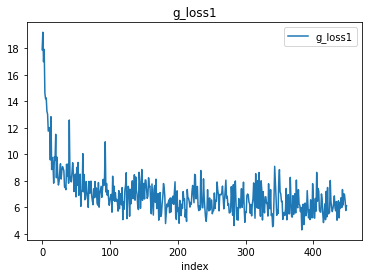

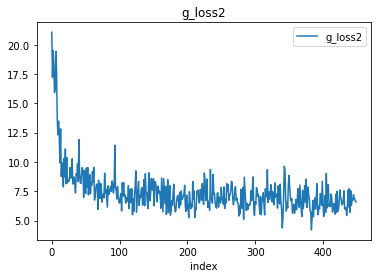

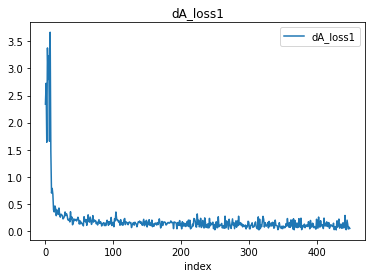

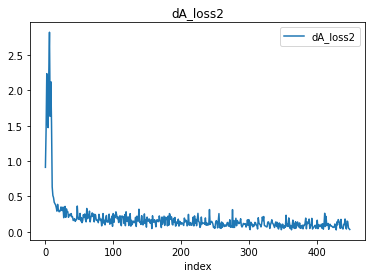

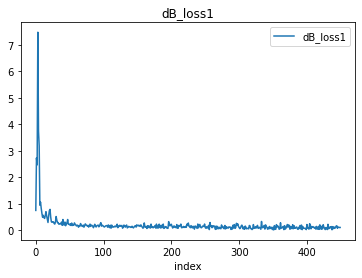

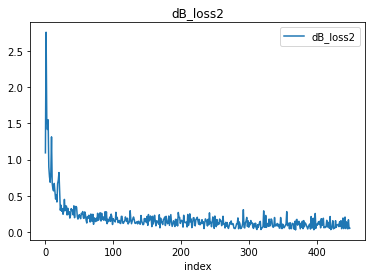

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('loss.csv')
df.columns=['index', 'g_loss1', 'g_loss2', 'dA_loss1', 'dA_loss2', 'dB_loss1',
       'dB_loss2']
df.head()
# figure,axes=plt.subplots(3,2)
for i in range(1,7):
    current_loss= df.columns[i]
    print(i)
    
    plot=df.plot('index',current_loss,kind='line',title=current_loss)
    fig=plot.get_figure()
    fig.savefig('{}.png'.format(current_loss))
#     print(current_loss)
# df.plot('index','g_loss1',kind='line')